# Multi Scale Network Analysis of Flight Data

The provided data contains information about the Airports with their geo-coordinates, and the flights data for a single month. For this report we will focus on the Countries: USA, UK, China, Australia and only on internal flight data. 

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


## Preliminary Data Cleaning and Pre-processing

In [ ]:
import pandas as pd 
import os 
import numpy as np


- Found corrupt file entry in line number 8864 of Airports.csv for "Sim��_��__��_��___��_��__��_��_____n Bol��_��__��_��___��_��__��_��_____var International,Venezuela,10.599444,-66.9825" , manually corrected the file entry to "

In [ ]:
# Data Files
data_dir = "/home/julian/git-repo/juliangdz/Multi-Scale-Network-Analysis-of-Flight-Data/data"
airport_dataframe = pd.read_csv(os.path.join(data_dir,'Airports.csv'))
flights_dataframe = pd.read_excel(os.path.join(data_dir,r'Flight Data.xlsx'))

In [ ]:
airport_dataframe.head()

In [ ]:
flights_dataframe.head()

In [ ]:
airport_dataframe[airport_dataframe[['Lon']].isna().any(axis=1)].shape[0]

In [ ]:
airport_dataframe.describe()

In [ ]:
flights_dataframe[flights_dataframe[['Weight']].isna().any(axis=1)].shape[0]

In [ ]:
flights_dataframe.describe()

- Check if Any Airports Flights Dataframe Not seen in Airports Dataframe - This will lead to Missing Geo Information

In [ ]:
flights_dataframe[~flights_dataframe['Source'].isin(airport_dataframe['id'])].shape

In [ ]:
flights_dataframe[~flights_dataframe['Target'].isin(airport_dataframe['id'])].shape

### Data Preprocessing


- Found Discrepencies in Country column for Airports.csv . Will proceed to correct the discrepencies observed using the Information from Flights Data excel by matching the Source and Source Country with the ID of the Airports.csv to correct the Country 

In [ ]:
def modify_country_information_based_on_infocus_countries(flights_df:pd.DataFrame,airports_df:pd.DataFrame,infocus_countries:dict):
    flights_df = flights_df.copy()
    airports_df = airports_df.copy()
    
    for key, value in infocus_countries.items():
        for country in value:
            flights_df.loc[flights_df['Source Country'] == country, 'Source Country'] = key
            flights_df.loc[flights_df['Target Country'] == country, 'Target Country'] = key
            airports_df.loc[airports_df['country'] == country, 'country'] = key

    return flights_df, airports_df

In [ ]:
in_focus_countries = {
    "USA":["United States","USA"],
    "China":["China"],
    "UK":["United Kingdom","UK"],
    "Australia":["Australia"]
}
modifed_flight_df,modified_airport_df = modify_country_information_based_on_infocus_countries(flights_dataframe,airport_dataframe,in_focus_countries)

- Filter the Dataframe to only include for Countries - US, UK, China, Australia
- Filter for Domestic Flights Only 

In [ ]:
def get_domestic_flights_for_countries(flights_df:pd.DataFrame,in_focus_countries:dict):
    # Filter for only In-Focus Countries
    _countries_list = list(in_focus_countries.keys())
    domestic_flights_list = []
    for country in _countries_list:
        domestic_flights = flights_df[(flights_df['Source Country']==country)&(flights_df['Target Country']==country)]
        domestic_flights_df = domestic_flights_list.append(domestic_flights)
    domestic_flights_df = pd.concat(domestic_flights_list,ignore_index=True)
    return domestic_flights_df

In [ ]:
domestic_flights_dataframe = get_domestic_flights_for_countries(modifed_flight_df,in_focus_countries)
domestic_flights_dataframe.head()

- Using the "id" field in airports_dataframe add the "Lat" and "Lon" information in the Flights Dataframe for both Source and Target 

In [ ]:
def validate_and_merge_data_corrected(flight_data, airport_data):
    """
    Corrected function to validate and merge flight data with airport data to include geographical coordinates.
    Adjusted to handle the correct column names for latitude and longitude.

    Parameters:
    flight_data (DataFrame): The flight data DataFrame.
    airport_data (DataFrame): The airport data DataFrame.

    Returns:
    DataFrame: Merged flight data with geographical coordinates.
    """
    # Adjusting column names for latitude and longitude
    airport_data = airport_data.rename(columns={'Lat ': 'Lat', 'Lon': 'Lon'})

    # Checking for mismatches or missing data in airport IDs
    missing_source_ids = flight_data[~flight_data['Source'].isin(airport_data['id'])]
    missing_target_ids = flight_data[~flight_data['Target'].isin(airport_data['id'])]

    # Merging flight data with airport data to include coordinates
    merged_data = flight_data.merge(
        airport_data[['id', 'Lat', 'Lon']], left_on='Source', right_on='id', how='left'
    ).rename(columns={'Lat': 'Source Lat', 'Lon': 'Source Lon'}).drop('id', axis=1)

    merged_data = merged_data.merge(
        airport_data[['id', 'Lat', 'Lon']], left_on='Target', right_on='id', how='left'
    ).rename(columns={'Lat': 'Target Lat', 'Lon': 'Target Lon'}).drop('id', axis=1)

    return merged_data, missing_source_ids, missing_target_ids


def data_integrity_checks(merged_data):
    # Identifying rows with missing coordinates
    missing_coordinates = merged_data[merged_data[['Source Lat', 'Source Lon', 'Target Lat', 'Target Lon']].isna().any(axis=1)]

    # Counting the number of missing coordinate entries
    missing_count = missing_coordinates.shape[0]

    # Checking for duplicates in the flight data
    duplicates_count = merged_data.duplicated(subset=['Source', 'Target']).sum()

    # Checking for any anomalies in flight weights (e.g., negative values or extremely high values)
    weight_issues = merged_data[merged_data['Weight'] <= 0]

    # Counting the number of weight issues
    weight_issues_count = weight_issues.shape[0]

    return missing_count, duplicates_count, weight_issues_count


In [ ]:
merged_flights_data_corrected, missing_source_ids_corrected, missing_target_ids_corrected = validate_and_merge_data_corrected(domestic_flights_dataframe, modified_airport_df)
data_integrity_checks(merged_flights_data_corrected)

- Found 49 Airports with Missing Lat and Lon Information in the Merged Dataframe. Will proceed to correct this using the IATA.csv 

In [ ]:
missing_coordinates = merged_flights_data_corrected[merged_flights_data_corrected[['Source Lat', 'Source Lon', 'Target Lat', 'Target Lon']].isna().any(axis=1)]
missing_coordinates.head()


To fix and correct this we use the iata.csv as reference guide to help fix our missing and inaccurate geo coordinates

IATA/ICAO List
This list contains the airport codes of [IATA airport code](https://en.wikipedia.org/wiki/International_Air_Transport_Association_airport_code) and [ICAO airport code](https://en.wikipedia.org/wiki/International_Civil_Aviation_Organization_airport_code) grouped based on the country code (ISO3166-1) and region name (ISO3166-2) supported in IP2Location geolocation database.


|Field Name|Description|
|---|---|
|country_code|Two-character country code based on ISO 3166.|
|region_name|Region or state name.|
|iata|Three-character code of IATA airport code.|
|icao|Four-character code of ICAO airport code.|
|airport|Airport name.|
|latitude|Latitude of the airport.|
|longitude|Longitude of the airport.|



The IATA/ICAO list data is licensed under [Creative Commons Attribution-ShareAlike 4.0 International License](https://creativecommons.org/licenses/by-sa/4.0/). It is free for personal or commercial use with attribution required by mentioning the use of this data as follows,
**This site or product includes IATA/ICAO List data available from <a href="https://www.ip2location.com">http://www.ip2location.com</a>.**

IATA is a registered trademark of International Air Transport Association.   
ICAO is a registered trademark of International Civil Aviation Organization.   
All other product names mentioned on this repository may be trademarks or registered trademarks of their respective companies.

In [ ]:
reference_airports_dataframe = pd.read_csv(os.path.join(data_dir,'iata_icao.csv'))
reference_airports_dataframe.head()

In [ ]:
def fix_geo_coordinates_for_airports(routes_df, iata_df):
    # Create a copy of the DataFrame to avoid modifying the original one
    routes_df = routes_df.copy()

    # Joining the DataFrames for Source
    source_df = pd.merge(routes_df, iata_df[['iata', 'latitude', 'longitude']], left_on='Source', right_on='iata', how='left')
    source_df.rename(columns={'latitude': 'new_source_lat', 'longitude': 'new_source_lon'}, inplace=True)

    # Joining the DataFrames for Target
    target_df = pd.merge(routes_df, iata_df[['iata', 'latitude', 'longitude']], left_on='Target', right_on='iata', how='left')
    target_df.rename(columns={'latitude': 'new_target_lat', 'longitude': 'new_target_lon'}, inplace=True)

    # Initialize counters
    source_updated_count = 0
    target_updated_count = 0

    # Updating Source Lat and Lon
    for index, row in routes_df.iterrows():
        new_lat, new_lon = source_df.at[index, 'new_source_lat'], source_df.at[index, 'new_source_lon']
        if pd.notna(new_lat) and pd.notna(new_lon):
            if pd.isna(row['Source Lat']) or pd.isna(row['Source Lon']) or \
               row['Source Lat'] != new_lat or row['Source Lon'] != new_lon:
                if pd.notna(row['Source Lat']) and pd.notna(row['Source Lon']):
                    source_updated_count += 1
                routes_df.at[index, 'Source Lat'] = new_lat
                routes_df.at[index, 'Source Lon'] = new_lon

        # Updating Target Lat and Lon
        new_lat, new_lon = target_df.at[index, 'new_target_lat'], target_df.at[index, 'new_target_lon']
        if pd.notna(new_lat) and pd.notna(new_lon):
            if pd.isna(row['Target Lat']) or pd.isna(row['Target Lon']) or \
               row['Target Lat'] != new_lat or row['Target Lon'] != new_lon:
                if pd.notna(row['Target Lat']) and pd.notna(row['Target Lon']):
                    target_updated_count += 1
                routes_df.at[index, 'Target Lat'] = new_lat
                routes_df.at[index, 'Target Lon'] = new_lon

    print(f"Number of Source records updated: {source_updated_count}")
    print(f"Number of Target records updated: {target_updated_count}")

    return routes_df

In [ ]:
updated_routes_dataframe = fix_geo_coordinates_for_airports(merged_flights_data_corrected,reference_airports_dataframe)
updated_routes_dataframe.head()

In [ ]:
updated_routes_dataframe[updated_routes_dataframe[['Source Lon','Source Lat','Target Lon','Target Lat']].isna().any(axis=1)]

- The Number of Missing Geo Records have reduced to 5 from 49. Using Online Resources the records can be updated. 

References: 
- "https://www.travelmath.com/airport/PNF"



In [ ]:
def update_geo_information_using_online_search(online_search: dict, routes_df: pd.DataFrame):
    # Iterate through each row in the DataFrame
    for index, row in routes_df.iterrows():
        # Check and update for Source
        if row['Source'] in online_search:
            routes_df.at[index, 'Source Lat'] = online_search[row['Source']][0]
            routes_df.at[index, 'Source Lon'] = online_search[row['Source']][1]

        # Check and update for Target
        if row['Target'] in online_search:
            routes_df.at[index, 'Target Lat'] = online_search[row['Target']][0]
            routes_df.at[index, 'Target Lon'] = online_search[row['Target']][1]

    return routes_df

# Dictionary with online search data
online_search = {
    'JGC': [35.951942, -112.1475],
    'PNF': [58.68333333, -156.83333333],
    'TIS': [-10.58666666, 142.28749999]
}

In [ ]:
updated_routes_df = update_geo_information_using_online_search(online_search, updated_routes_dataframe)
updated_routes_df.head()

In [ ]:
print(updated_routes_df[updated_routes_df[['Source Lon','Source Lat','Target Lon','Target Lat']].isna().any(axis=1)])

In [ ]:
updated_routes_df.describe()

- Check for Duplicate Routes - This is to be handled by taking the sum of weights

In [ ]:
def fixing_for_duplicate_routes(routes_df):
    # Group by 'Source' and 'Target' and sum the 'Weight'
    routes_grouped = routes_df.groupby(['Source', 'Target']).agg({'Weight': 'sum'}).reset_index()

    # Merging the grouped data back with the original dataframe to retain other columns
    # This step ensures we keep one set of lat/lon for each route
    routes_df_deduped = routes_df.drop('Weight', axis=1).drop_duplicates(subset=['Source', 'Target'])
    routes_df_fixed = pd.merge(routes_df_deduped, routes_grouped, on=['Source', 'Target'], how='left')

    return routes_df_fixed

In [ ]:
# Applying the function to the updated routes dataframe
fixed_routes_df = fixing_for_duplicate_routes(updated_routes_df)
# Displaying the first few rows of the fixed DataFrame
fixed_routes_df.head()

In [ ]:
# Checking for duplicates in the flight data
fixed_routes_df.duplicated(subset=['Source', 'Target']).sum()

In [ ]:
fixed_routes_df.describe()

- All Geo Information has been fixed and corrected 
- All Duplicated routes have been handled with sum of weights 
- No unreasonable Weights found 

In [ ]:
fixed_routes_df.to_csv(os.path.join(data_dir,'cleaned_routes.csv'),index=False)

##
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


## Network Visualization 

- Visualize for Domestic Network 1 single image for all the countries in the fixed_routes_df
- Visualize for Each Country Seperately - Map Visualization, Busy Airports Visualization, Without Map Plane Network Visualization 

In [ ]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt 
import networkx as nx

# Function to create a Basemap network plot for a given country
def create_basemap_network_plot(data, country, llcrnrlon, llcrnrlat, urcrnrlon, urcrnrlat,mode='simple',show_cmap=False):
    # Filter data for the country
    country_data = data[data['Source Country'] == country]

    # Create a graph
    G = nx.Graph()

    # Add nodes with attributes
    for _, row in country_data.iterrows():
        G.add_node(row['Source'], pos=(row['Source Lon'], row['Source Lat']), weight=row['Weight'])
        G.add_node(row['Target'], pos=(row['Target Lon'], row['Target Lat']), weight=row['Weight'])
        G.add_edge(row['Source'], row['Target'], weight=row['Weight'])

    

    # Node positions
    pos = nx.get_node_attributes(G, 'pos')

    # Set up base map
    plt.figure(figsize=(15, 20))
    m = Basemap(projection='merc', llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat,
                urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat, lat_ts=0, resolution='l', suppress_ticks=True)

    # Convert longitudes and latitudes to map coordinates
    pos_on_map = {node: m(*pos[node]) for node in pos}

    # Draw nodes and edges
    if mode == 'advanced':
        # Node size and color based on weights
        weights = np.array([data['weight'] for _, data in G.nodes(data=True)])
        node_size = 100 * (weights / weights.max())
        node_color = node_size
        
        nx.draw_networkx_nodes(G, pos_on_map, node_size=node_size, node_color=node_color, cmap=plt.cm.viridis, alpha=0.99)
        nx.draw_networkx_edges(G, pos_on_map, alpha=0.15,edge_color="gray")
    else:
        nx.draw_networkx_nodes(G, pos_on_map, node_size=50, node_color="blue", alpha=0.99)
        nx.draw_networkx_edges(G, pos_on_map, alpha=0.15,edge_color="gray")
    # Draw map details
    m.drawcountries(linewidth=0.1)
    m.drawstates(linewidth=0.1)
    m.drawcoastlines(linewidth=0.1)

    plt.title(f"Flight Network in {country}")
    if show_cmap:
        plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.viridis), ax=plt.gca(), orientation='vertical', label='Relative Busyness')
    plt.show()
    
def plot_airport_network(country_dataframe: pd.DataFrame, threshold_routes: int = 30, use_averaging: bool = False, use_top_k: bool = False, top_k: int = 10):
    """
    Plots a network graph of airports with nodes sized and colored according to the number of routes.
    Can use threshold value as the average route count if use_averaging is true, else will use the threshold_routes value, else if use_top_k is given will check route counts and only show the airport ID and larger size for the top k airports depending on value from top_k variable.
    
    Parameters:
    country_dataframe (pd.DataFrame): DataFrame containing airport route information.
    threshold_routes (int): The fixed threshold number of routes to determine node sizes and colors.
    use_averaging (bool): Whether to use the average route count as the threshold.
    use_top_k (bool): Whether to highlight only the top k airports with the most routes.
    top_k (int): The number of top airports to highlight.
    """
    # Calculate the number of routes for each airport
    route_counts = pd.concat([country_dataframe['Source'], country_dataframe['Target']]).value_counts()

    # Determine the threshold for highlighting airports
    if use_averaging:
        threshold_routes = int(route_counts.mean())
    elif use_top_k:
        threshold_routes = route_counts.nlargest(top_k).iloc[-1]  # Get the route count of the k-th airport

    # Create the network graph
    G = nx.Graph()
    for index, row in country_dataframe.iterrows():
        G.add_edge(row['Source'], row['Target'], weight=row['Weight'])

    # Create a unique set of airports from both Source and Target
    all_airports = pd.concat([country_dataframe['Source'], country_dataframe['Target']]).unique()

    # Initialize a position dictionary for all airports
    pos = {}
    for airport in all_airports:
        # Attempt to get position from 'Source' data
        source_pos = country_dataframe[country_dataframe['Source'] == airport][['Source Lon', 'Source Lat']].head(1).values
        # If not found, get position from 'Target' data
        target_pos = country_dataframe[country_dataframe['Target'] == airport][['Target Lon', 'Target Lat']].head(1).values
        # Use the first valid position found
        pos[airport] = tuple(source_pos[0]) if len(source_pos) > 0 else tuple(target_pos[0])

    # Set node attributes for sizes and labels based on the threshold
    high_route_size = 300  # Size for airports above the threshold
    low_route_size = 30    # Size for airports below the threshold
    high_route_color = 'red'    # Color for airports above the threshold
    low_route_color = 'green'   # Color for airports below the threshold
    for node in G.nodes():
        count = route_counts.get(node, 0)
        G.nodes[node]['size'] = high_route_size if count >= threshold_routes else low_route_size
        G.nodes[node]['color'] = high_route_color if count >= threshold_routes else low_route_color
        G.nodes[node]['label'] = node if count >= threshold_routes else ''

    # Draw the graph
    plt.figure(figsize=(15, 15))
    nx.draw_networkx_edges(G, pos, alpha=0.4)
    nx.draw_networkx_nodes(G, pos, node_size=[G.nodes[node]['size'] for node in G.nodes],
                           node_color=[G.nodes[node]['color'] for node in G.nodes], alpha=0.6)
    nx.draw_networkx_labels(G, pos, labels={node: G.nodes[node]['label'] for node in G.nodes if G.nodes[node]['label']}, font_size=8)

    plt.axis('off')
    plt.show()
    

def plot_route_counts_bar(country_dataframe: pd.DataFrame, threshold_routes: int = 30, use_averaging: bool = False, use_top_k: bool = False, top_k: int = 10):
    """
    Plots a horizontal bar plot of airport IDs against their route counts based on filter criteria.
    Will plot only airport IDs that are above average if using averaging, else use the threshold_routes value,
    or plot for top k based on the top_k value.

    Parameters:
    country_dataframe (pd.DataFrame): DataFrame containing airport route information.
    threshold_routes (int): The fixed threshold number of routes to determine which airports to plot.
    use_averaging (bool): Whether to use the average route count as the threshold for plotting.
    use_top_k (bool): Whether to plot only the top k airports with the most routes.
    top_k (int): The number of top airports to plot.
    """
    # Calculate the number of routes for each airport
    route_counts = pd.concat([country_dataframe['Source'], country_dataframe['Target']]).value_counts()

    # Determine the threshold for plotting
    if use_averaging:
        threshold_routes = int(route_counts.mean())
    elif use_top_k:
        # Get the route counts for the top k airports
        route_counts = route_counts.nlargest(top_k)
    else:
        # Filter out airports below the threshold
        route_counts = route_counts[route_counts >= threshold_routes]

    # Plot only the airports that satisfy the filter criteria
    filtered_route_counts = route_counts[route_counts >= threshold_routes]

    # Create the bar plot
    plt.figure(figsize=(10, len(filtered_route_counts) * 0.5))  # Adjust the figure size based on the number of airports
    filtered_route_counts.sort_values().plot(kind='barh', color='skyblue')
    plt.xlabel('Route Count')
    plt.ylabel('Airport ID')
    # plt.title('Airport Route Counts for Filtered Airports')

    # Add route count labels on the bars
    for index, value in enumerate(filtered_route_counts.sort_values()):
        plt.text(value, index, str(value))

    plt.tight_layout()
    plt.show()

def get_country_dataframe(datframe:pd.DataFrame,country:str):
    country_dataframe = datframe[datframe['Source Country'] == country]
    country_dataframe.head()
    return country_dataframe

In [ ]:
# Coordinates for bounding boxes for each country
bounding_boxes = {
    'USA': [-180, 10, -50, 70],
    'UK': [-10, 50, 2, 60],
    'China': [73, 18, 135, 54],
    'Australia': [113, -44, 154, -10]
}


#### Networks Visualizations for USA

In [ ]:
usa_dataframe = get_country_dataframe(fixed_routes_df,"USA")
usa_dataframe.head()

In [ ]:
usa_dataframe.describe()

In [ ]:
# Create Basemap network plots for each country
create_basemap_network_plot(fixed_routes_df, "USA", *bounding_boxes["USA"],mode='simple')

- Using the weights to use some color gradient and dynamic node size so as to visualize node/ airports that have larger weights - here we use relative weights. Weights signify the maximum capacity 

In [ ]:
# Create Basemap network plots for each country
create_basemap_network_plot(fixed_routes_df, "USA", *bounding_boxes["USA"],mode='advanced',show_cmap=False)

- By Checking the number of routes for each airport and Displaying airport ID for airports having greater than average number of route connections. Signifying Popularity of airports. 

In [ ]:
plot_airport_network(usa_dataframe,use_averaging=True)

- Visualize the Route Counts for the Airport nodes highlighted, that have greater than average connections - signifying some degree of popularity or connectivity for these airports. 


In [ ]:
plot_route_counts_bar(usa_dataframe,use_averaging=True)

- Lets visualize the top 10 airports with highest number of connections 

In [ ]:
plot_airport_network(usa_dataframe,use_top_k=True,top_k=10)

In [ ]:
plot_route_counts_bar(usa_dataframe,use_top_k=True,top_k=10)

#### Network Visualization for UK

In [ ]:
uk_dataframe = get_country_dataframe(fixed_routes_df,"UK")
uk_dataframe.head()

In [ ]:
uk_dataframe.describe()

In [ ]:
# Create Basemap network plots for each country
create_basemap_network_plot(fixed_routes_df, "UK", *bounding_boxes["UK"],mode='simple')

- Using the weights to use some color gradient and dynamic node size so as to visualize node/ airports that have larger weights - here we use relative weights. Weights signify the maximum capacity 

In [ ]:
# Create Basemap network plots for each country
create_basemap_network_plot(fixed_routes_df, "UK", *bounding_boxes["UK"],mode='advanced',show_cmap=False)

- By Checking the number of routes for each airport and Displaying airport ID for airports having greater than average number of route connections. Signifying Popularity of airports. 

In [ ]:
plot_airport_network(uk_dataframe,use_averaging=True)

- Visualize the Route Counts for the Airport nodes highlighted, that have greater than average connections - signifying some degree of popularity or connectivity for these airports. 


In [ ]:
plot_route_counts_bar(uk_dataframe,use_averaging=True)

- Lets visualize the top 10 airports with highest number of connections 

In [ ]:
plot_airport_network(uk_dataframe,use_top_k=True,top_k=10)

In [ ]:
plot_route_counts_bar(uk_dataframe,use_top_k=True,top_k=10)

#### Network Visualization for China

In [ ]:
china_dataframe = get_country_dataframe(fixed_routes_df,"China")
china_dataframe.head()

In [ ]:
china_dataframe.describe()

In [ ]:
# Create Basemap network plots for each country
create_basemap_network_plot(fixed_routes_df, "China", *bounding_boxes["China"],mode='simple')

- Using the weights to use some color gradient and dynamic node size so as to visualize node/ airports that have larger weights - here we use relative weights. Weights signify the maximum capacity 

In [ ]:
# Create Basemap network plots for each country
create_basemap_network_plot(fixed_routes_df, "China", *bounding_boxes["China"],mode='advanced',show_cmap=False)

- By Checking the number of routes for each airport and Displaying airport ID for airports having greater than average number of route connections. Signifying Popularity of airports. 

In [ ]:
plot_airport_network(china_dataframe,use_averaging=True)

- Visualize the Route Counts for the Airport nodes highlighted, that have greater than average connections - signifying some degree of popularity or connectivity for these airports. 


In [ ]:
plot_route_counts_bar(china_dataframe,use_averaging=True)

- Lets visualize the top 10 airports with highest number of connections 

In [ ]:
plot_airport_network(china_dataframe,use_top_k=True,top_k=10)

In [ ]:
plot_route_counts_bar(china_dataframe,use_top_k=True,top_k=10)

#### Network Visualization for Australia

In [ ]:
australia_dataframe = get_country_dataframe(fixed_routes_df,"Australia")
australia_dataframe.head()

In [ ]:
australia_dataframe.describe()

In [ ]:
# Create Basemap network plots for each country
create_basemap_network_plot(fixed_routes_df, "Australia", *bounding_boxes["Australia"],mode='simple')

- Using the weights to use some color gradient and dynamic node size so as to visualize node/ airports that have larger weights - here we use relative weights. Weights signify the maximum capacity 

In [ ]:
# Create Basemap network plots for each country
create_basemap_network_plot(fixed_routes_df, "Australia", *bounding_boxes["Australia"],mode='advanced',show_cmap=False)

- By Checking the number of routes for each airport and Displaying airport ID for airports having greater than average number of route connections. Signifying Popularity of airports. 

In [ ]:
plot_airport_network(australia_dataframe,use_averaging=True)

- Visualize the Route Counts for the Airport nodes highlighted, that have greater than average connections - signifying some degree of popularity or connectivity for these airports. 


In [ ]:
plot_route_counts_bar(australia_dataframe,use_averaging=True)

- Lets visualize the top 10 airports with highest number of connections 

In [ ]:
plot_airport_network(australia_dataframe,use_top_k=True,top_k=10)

In [ ]:
plot_route_counts_bar(australia_dataframe,use_top_k=True,top_k=10)

##
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Network Analysis

Implement graph analysis across 3 different graph scales: 1) macro-scale (statistical analysis), 2) meso-scale (community analysis), 3) node-level (centrality analysis).

- Analyze the Degreee Distribution for Each Country (Macro-Scale Analysis)
- Analyze the Degree vs Betweeness (Node Level Analysis / Micro-Scale Analysis)
- Analyze the Assortativity (degree-degree correlation) 
- Core Community Size Analysis (Meso-Scale analysis)


1. Macro-Scale (Statistical Analysis): Degree Distribution
We will calculate and visualize the degree distribution of this network. The degree of a node in a graph indicates the number of connections it has. In our case, it represents the number of direct flight connections an airport has. This analysis helps in understanding the general structure of the network, such as whether it's dominated by a few highly connected nodes or if connections are more evenly distributed.

2. Micro-Scale (Node-Level Analysis): Degree vs. Betweenness
We will calculate the betweenness centrality for each node and plot it against its degree. Betweenness centrality measures the number of shortest paths that pass through a node. In the context of flight networks, a high betweenness centrality indicates an airport's strategic importance as a connecting hub.

3. Analyze the Assortativity
We will calculate the assortativity coefficient of the network, which measures the similarity of connections in the graph with respect to the node degree. This will tell us if airports with similar numbers of connections tend to be connected to each other.

4. Meso-Scale (Community Analysis): Core Community Size Analysis
We will use algorithms to detect communities within the network and analyze the size of these communities. This can reveal how the flight network is regionally structured or functionally partitioned.

### Macro-Scale Analysis (Statistical Analaysis) - Degree Distribution 

- In-Degree: The number of routes coming into a location.
- Out-Degree: The number of routes going out from a location.
- Overall Degree: The total number of incoming and outgoing routes for a location.

In [76]:
def plot_degree_vs_frequency_distribution(country_dataframe: pd.DataFrame):
    """
    Plots the degree vs frequency distribution as histograms for a given country's route data.

    :param country_dataframe: DataFrame containing route data for a specific country.
    """
    # Calculating in-degree, out-degree, and overall degree for each location
    in_degree = country_dataframe['Target'].value_counts()
    out_degree = country_dataframe['Source'].value_counts()
    overall_degree = in_degree.add(out_degree, fill_value=0)

    # Converting Series to DataFrames for easier handling
    in_degree_df = in_degree.reset_index()
    in_degree_df.columns = ['Location', 'In-Degree']

    out_degree_df = out_degree.reset_index()
    out_degree_df.columns = ['Location', 'Out-Degree']

    overall_degree_df = overall_degree.reset_index()
    overall_degree_df.columns = ['Location', 'Overall-Degree']

    # Setting up subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Plotting histograms for in-degree, out-degree, and overall degree
    axs[0].hist(in_degree_df['In-Degree'], bins=30, color='skyblue', edgecolor='black')
    axs[0].set_title('Histogram of In-Degree Distribution')
    axs[0].set_xlabel('In-Degree')
    axs[0].set_ylabel('Frequency')

    axs[1].hist(out_degree_df['Out-Degree'], bins=30, color='skyblue', edgecolor='black')
    axs[1].set_title('Histogram of Out-Degree Distribution')
    axs[1].set_xlabel('Out-Degree')

    axs[2].hist(overall_degree_df['Overall-Degree'], bins=30, color='skyblue', edgecolor='black')
    axs[2].set_title('Histogram of Overall Degree Distribution')
    axs[2].set_xlabel('Overall Degree')

    plt.tight_layout()
    plt.show()
    

def plot_log_weighted_degree_vs_descending_rank(country_dataframe: pd.DataFrame):
    """
    Plots the logarithmic scale of in-degree, out-degree, and overall-degree 
    against their descending rank for each location in a given country's dataframe.

    :param country_dataframe (pd.DataFrame): A dataframe containing 'Source' and 'Target' columns
                                      representing connections between locations.

    """
    # Calculating in-degree, out-degree, and overall degree for each location
    in_degree = country_dataframe['Target'].value_counts()
    out_degree = country_dataframe['Source'].value_counts()
    overall_degree = in_degree.add(out_degree, fill_value=0)

    # Converting Series to DataFrames for easier handling
    in_degree_df = in_degree.reset_index()
    in_degree_df.columns = ['Location', 'In-Degree']

    out_degree_df = out_degree.reset_index()
    out_degree_df.columns = ['Location', 'Out-Degree']

    overall_degree_df = overall_degree.reset_index()
    overall_degree_df.columns = ['Location', 'Overall-Degree']
    
    # Ranking the locations based on their weighted degrees
    in_degree_ranked = in_degree_df.sort_values('In-Degree', ascending=False).reset_index(drop=True)
    out_degree_ranked = out_degree_df.sort_values('Out-Degree', ascending=False).reset_index(drop=True)
    overall_degree_ranked = overall_degree_df.sort_values('Overall-Degree', ascending=False).reset_index(drop=True)

    # Adding rank columns
    in_degree_ranked['Rank'] = in_degree_ranked.index + 1
    out_degree_ranked['Rank'] = out_degree_ranked.index + 1
    overall_degree_ranked['Rank'] = overall_degree_ranked.index + 1

    # Function to plot rank vs log scale of degree
    def plot_rank_vs_log_degree(ax, data, degree_column, title):
        ax.plot(data['Rank'], np.log(data[degree_column]), marker='o', linestyle='-', color='skyblue')
        ax.set_title(title)
        ax.set_xlabel('Rank (Descending)')
        ax.set_ylabel('Log of Degree')
        ax.invert_xaxis()  # Inverting x-axis for descending rank

    # Creating subplots
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

    # Plotting rank vs log scale of degree for in-degree, out-degree, and overall degree
    plot_rank_vs_log_degree(axes[0], in_degree_ranked, 'In-Degree', 'Rank vs Log of In-Degree')
    plot_rank_vs_log_degree(axes[1], out_degree_ranked, 'Out-Degree', 'Rank vs Log of Out-Degree')
    plot_rank_vs_log_degree(axes[2], overall_degree_ranked, 'Overall-Degree', 'Rank vs Log of Overall Degree')

    plt.tight_layout()
    plt.show()
    
    return in_degree_ranked,out_degree_ranked,overall_degree_ranked


#### Macro-Scale Analysis for USA

- Plot for Degree vs Frequency

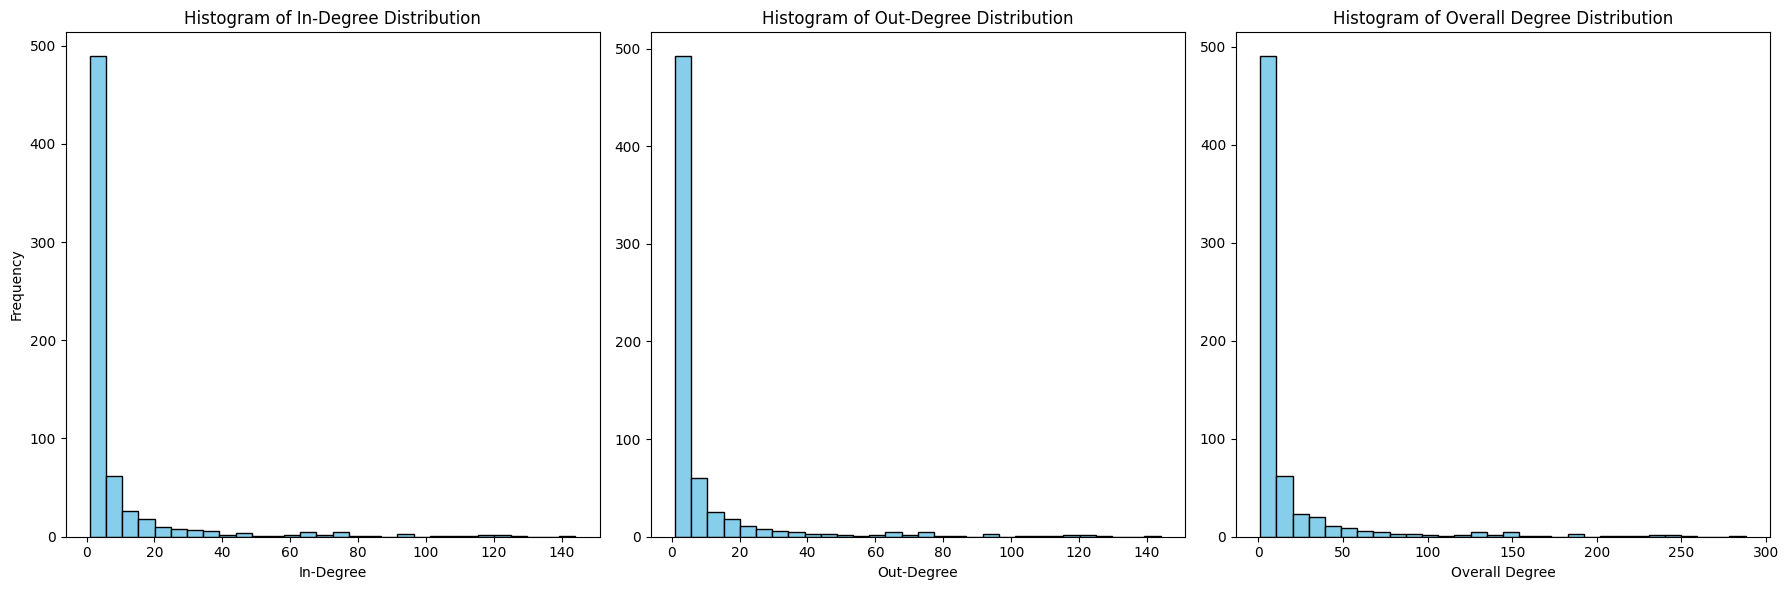

In [70]:
plot_degree_vs_frequency_distribution(usa_dataframe)

- Lets plot the weighted_degree vs rank 

These plots provide a way to visualize the distribution of degrees in a network where the differences in degree magnitudes are significant. They highlight the existence of highly connected hubs (locations with very high degrees) in contrast to most other locations that have significantly lower connectivity.

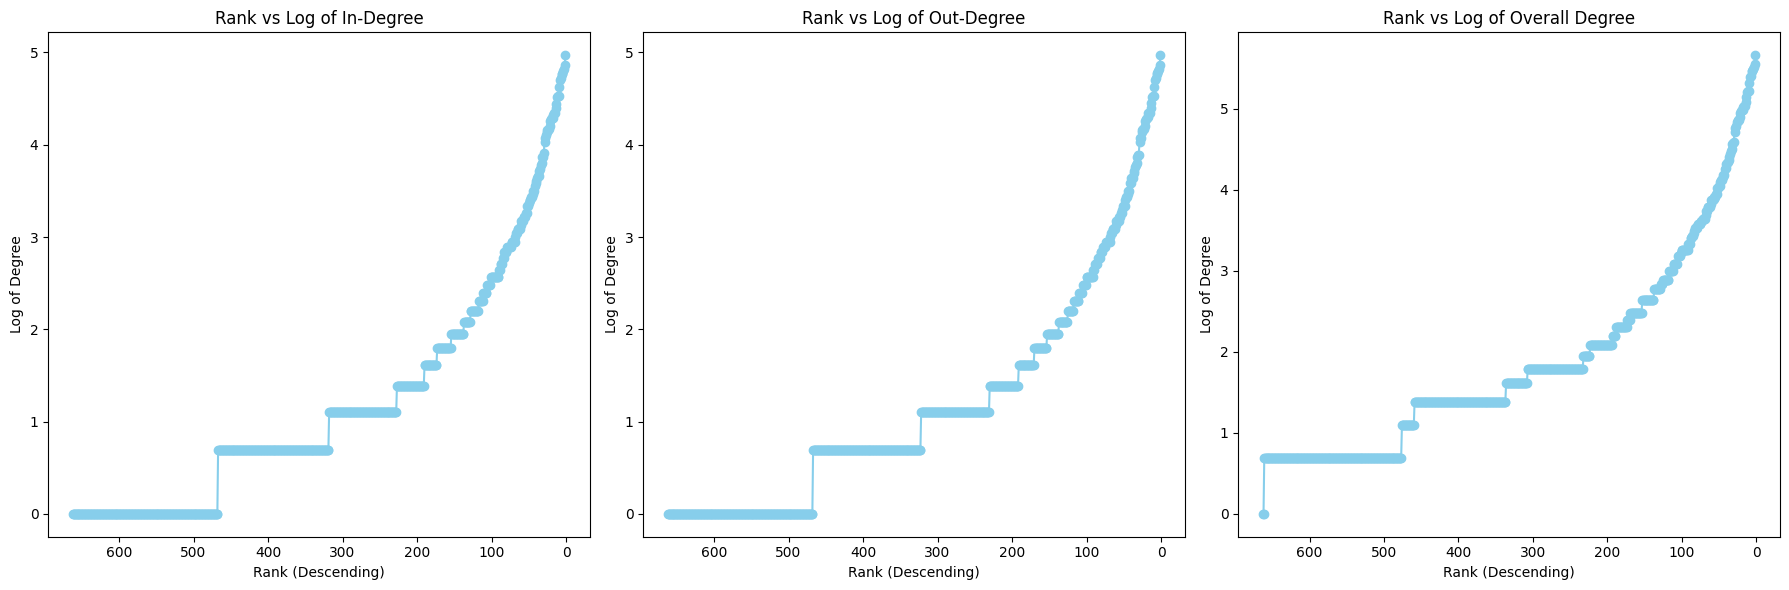

In [77]:
usa_in_degree_ranked,usa_out_degree_ranked,usa_overall_degree_ranked = plot_log_weighted_degree_vs_descending_rank(usa_dataframe)

- Plot network plot for in-degree, out-degree and overll degree showing airport ID using topK 